**Synthetic Data Generation Using Bayesian Method Based on Distribution**

**1. Import Dataset**

In [ ]:
#Download dataset from: https://drive.google.com/file/d/1xu_xdVySieNg1vjqPskRyGSARA-YDK1N/view?usp=sharing
!gdown --id 1xu_xdVySieNg1vjqPskRyGSARA-YDK1N

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xu_xdVySieNg1vjqPskRyGSARA-YDK1N
To: /content/database.txt
100% 1.90M/1.90M [00:00<00:00, 154MB/s]


In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 12.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az
pd.options.display.float_format = '{:.2f}'.format
import scipy
# import blackjax
# import numpyro
# import posterior

import matplotlib.pyplot  as plt
import seaborn as sns
sns.set()

import scipy.io
import scipy.optimize

from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal
import matplotlib.cm as cm
from matplotlib.lines import Line2D

In [ ]:
file_path = 'database.txt'
datt = pd.read_fwf(file_path, header=None)
datt

,0,1,2,3,4,5,6,7,8,9,...,979,980,981,982,983,984,985,986,987,988
0,1.00,1.00,1.00,1.00,0.97,0.97,0.96,0.96,0.96,0.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.99,0.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.00,1.00,0.99,0.99,0.99,0.98,0.98,0.94,0.94,0.92,...,0.98,0.99,0.99,1.00,1.00,NaN,NaN,NaN,NaN,NaN
3,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.98,0.98,0.98,...,0.95,0.95,0.96,0.96,0.97,0.98,0.98,0.99,1.00,1.00
4,1.00,1.00,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,1.00,1.00,0.99,0.98,0.98,0.98,0.97,0.96,0.96,0.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,1.00,0.99,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,1.00,1.00,1.00,0.99,0.99,0.95,0.95,0.95,0.94,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
series_list = []

for i in range(0, 377):
    series = datt.iloc[i].dropna().reset_index(drop=True).squeeze()
    series_list.append(series)

series_list

[0     1.00000000
 1     1.00000000
 2     0.99570000
 3     0.99570000
 4     0.97020000
          ...    
 818   0.97870000
 819   0.98720000
 820   0.99150000
 821   0.99570000
 822   1.00000000
 Name: 0, Length: 823, dtype: float64,
 0     1.00000000
 1     1.00000000
 2     1.00000000
 3     0.99650000
 4     0.99650000
          ...    
 685   0.96890000
 686   0.98960000
 687   0.98960000
 688   0.99650000
 689   1.00000000
 Name: 1, Length: 690, dtype: float64,
 0     1.00000000
 1     0.99620000
 2     0.99250000
 3     0.99250000
 4     0.98870000
          ...    
 979   0.98120000
 980   0.98870000
 981   0.99250000
 982   0.99620000
 983   1.00000000
 Name: 2, Length: 984, dtype: float64,
 0     1.00000000
 1     1.00000000
 2     0.99640000
 3     0.98930000
 4     0.98580000
          ...    
 984   0.97510000
 985   0.97860000
 986   0.98580000
 987   0.99640000
 988   1.00000000
 Name: 3, Length: 989, dtype: float64,
 0     1.00000000
 1     0.99630000
 2     0.9926000

In [ ]:
last_values = []

for series in series_list:
    last_value = series.iloc[-1]
    last_values.append(last_value)
    series = series.iloc[:-1]  # Drop the last value from the series

new_series = pd.Series(last_values)

In [ ]:
new_series

0     1.00000000
1     1.00000000
2     1.00000000
3     1.00000000
4     1.00000000
         ...    
372   5.00000000
373   5.00000000
374   5.00000000
375   5.00000000
376   5.00000000
Length: 377, dtype: float64

In [ ]:
y = pd.Series(new_series)
len(y)

377

In [ ]:
print(utils.multiclass.type_of_target(y))

continuous


our label read as continuous label, so we need to convert it to multiclass label

In [ ]:
# Convert continuous data to categorical labels
yy = np.round(y).astype(int)

# Print the converted categorical labels
print(yy)

0      1
1      1
2      1
3      1
4      1
      ..
372    5
373    5
374    5
375    5
376    5
Length: 377, dtype: int64


In [ ]:
print(utils.multiclass.type_of_target(yy))

multiclass


In [ ]:
new_series_list = []

for series in series_list:
    last_value2 = series.iloc[-1]
    new_series2 = series.iloc[:-1]  # Drop the last value from the series
    new_series_list.append(new_series2)

series_list2 = new_series_list

In [ ]:
from tslearn.utils import to_time_series_dataset
X = to_time_series_dataset(series_list2)
X

array([[[1.    ],
        [1.    ],
        [0.9957],
        ...,
        [   nan],
        [   nan],
        [   nan]],

       [[1.    ],
        [1.    ],
        [1.    ],
        ...,
        [   nan],
        [   nan],
        [   nan]],

       [[1.    ],
        [0.9962],
        [0.9925],
        ...,
        [   nan],
        [   nan],
        [   nan]],

       ...,

       [[1.    ],
        [1.    ],
        [1.    ],
        ...,
        [   nan],
        [   nan],
        [   nan]],

       [[1.    ],
        [0.9953],
        [1.    ],
        ...,
        [   nan],
        [   nan],
        [   nan]],

       [[1.    ],
        [0.9873],
        [0.9831],
        ...,
        [   nan],
        [   nan],
        [   nan]]])

In [ ]:
from tslearn.preprocessing import TimeSeriesResampler

resampled_X = TimeSeriesResampler(sz=X.shape[1]).fit_transform(X)
resampled_X

array([[[1.        ],
        [1.        ],
        [0.9971464 ],
        ...,
        [0.9886464 ],
        [0.99220638],
        [0.9957    ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.9896    ],
        [0.99169027],
        [0.9965    ]],

       [[1.        ],
        [0.99621925],
        [0.99253749],
        ...,
        [0.9887385 ],
        [0.99251874],
        [0.9962    ]],

       ...,

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.9860383 ],
        [0.9881    ],
        [0.9881    ]],

       [[1.        ],
        [0.99720476],
        [0.99619048],
        ...,
        [0.9906    ],
        [0.99250476],
        [0.9953    ]],

       [[1.        ],
        [0.99235684],
        [0.98644468],
        ...,
        [0.98644468],
        [0.9906845 ],
        [0.9958    ]]])

The dataset is time series data comes from leaf shape and have different size of series, when read dataset as Data Frame it shows blank space that is not represent the leaf shape filling as NaN or missing value automatically by Pandas Data Frame. 

We can't handle this different sizes with any handling missing values method, since it will change the shape of leaf and data distribution around it. 

Thus, more observing this dataset is needed to understand what kind approach we needed

In [ ]:
resampled_X.shape

(377, 988, 1)

It shows, the dataset contains 377 rows which represent number of leaf shape inside time series data

Column represent the length of of contour for every leaf shape series. 989 columns represent the longest contour of leaf shape series inside time series data. And every line not have same length since there are 377 different leaf shape series there. 

Draw the shape of leaf to have better view about the dataset

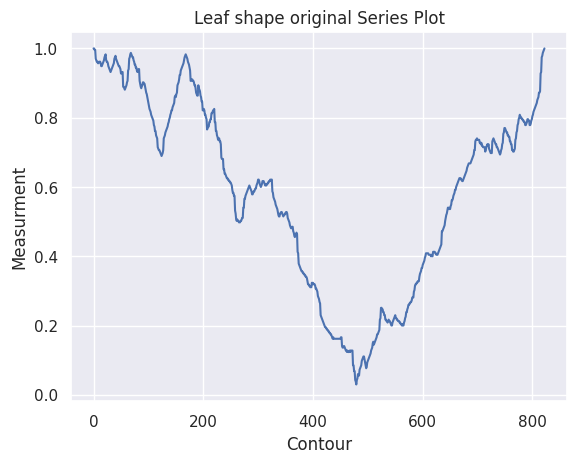

In [ ]:
series_ori = datt.iloc[0]  # Extract the series from index 0

# Plot the series
plt.plot(series_ori.index, series_ori.values)
plt.xlabel('Contour')
plt.ylabel('Measurment')
plt.title('Leaf shape original Series Plot')
plt.show()

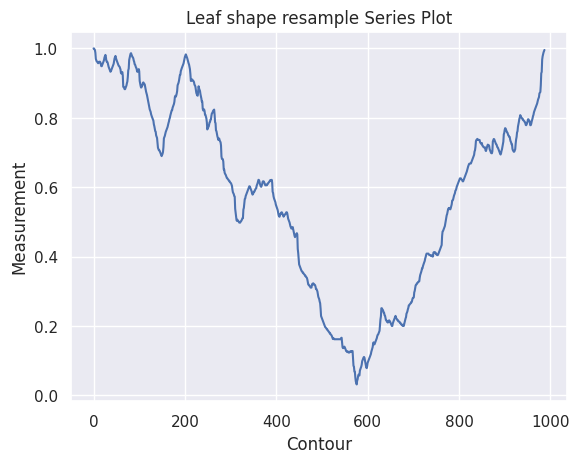

In [ ]:
series_resample = resampled_X[0, :, 0]  # Extract the series from index 0

# Plot the series
plt.plot(series_resample)
plt.xlabel('Contour')
plt.ylabel('Measurement')
plt.title('Leaf shape resample Series Plot')
plt.show()

show data distribution of leaf shape

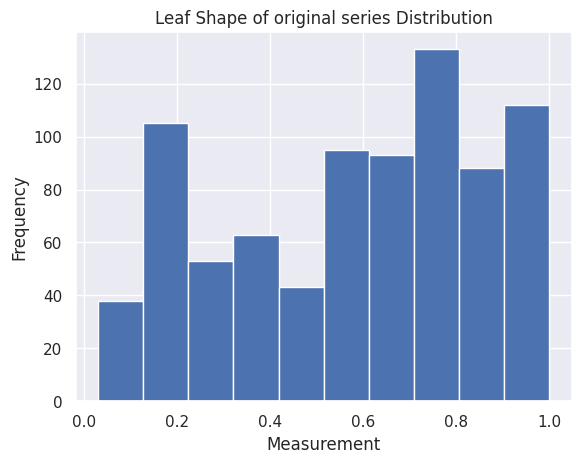

In [ ]:
# data = resampled_X

plt.hist(series_ori.values)
plt.title('Leaf Shape of original series Distribution')
plt.xlabel('Measurement')
plt.ylabel('Frequency')
plt.show()

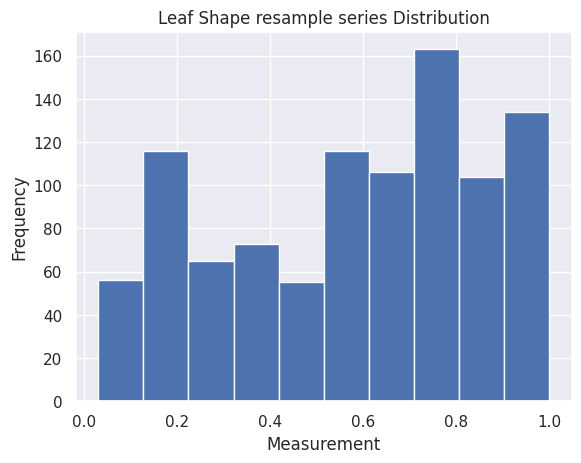

In [ ]:
# data = resampled_X

plt.hist(series_resample)
plt.title('Leaf Shape resample series Distribution')
plt.xlabel('Measurement')
plt.ylabel('Frequency')
plt.show()

Show data distribution with gaussian interference

([<matplotlib.axis.YTick at 0x7f03df4eac80>], [Text(0, 0, '0')])

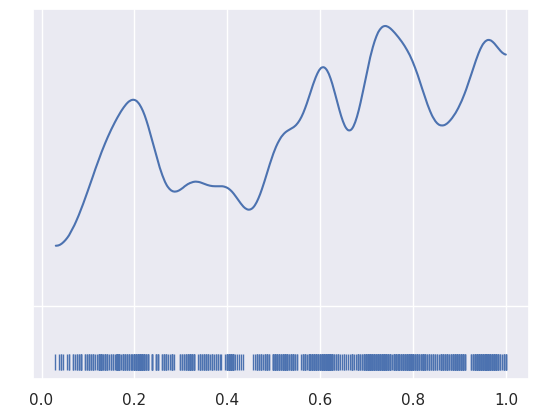

In [ ]:
%matplotlib inline

az.plot_kde(series_ori.values, rug=True)
plt.yticks([0], alpha=0)

([<matplotlib.axis.YTick at 0x7f03df14a0b0>], [Text(0, 0, '0')])

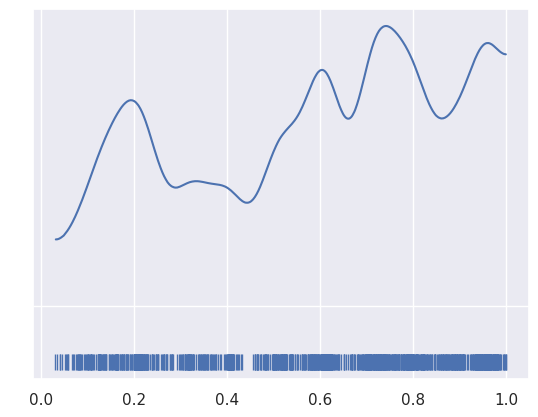

In [ ]:
%matplotlib inline

az.plot_kde(series_resample, rug=True)
plt.yticks([0], alpha=0)

The KDE plot of leaf shape shows a Gaussian-like distribution, It shows that most of the value in dataset is around 0 to 1

Let's assume that a Gaussian distribution is a proper description of the leaf shape time series data. Since we do not know the mean or the standard deviation, we must set priors for both of them.

In [ ]:
print('Running on PyMC v{}'.format(pm.__version__))

Running on PyMC v5.1.2


## Model

We will perform Gaussian inferences on the leaf shape time series data. Here's some of the modelling choices that go into this.

Choices for leaf shape likelihood function:

The leaf shape data is modelled as a linear combination of the independent variables. We assume that the leaf shape time series data is going to be normally distributed around the linear combination of independent variables with the same variance around the expected value.

That is how we proceed below:

In [ ]:
with model:
    trace = pm.sample(iterations, tune=burn_in)

In [ ]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=1) #Use any prior knowledge 
    sigma = pm.HalfNormal('sigma', sigma=10) 
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=resampled_X)
    
    trace = pm.sample(1000, tune=1000)
    # trace = pm.sample(1000, tune=1000, return_inferencedata=False)

We instantiate the Models in PyMC5 like above.

model specifications in PyMC5 are wrapped in a with-statement.
Choices of priors:

- mu, mean of a population. Normal distribution. We do not know the possible values of mean, we can set priors reflecting our ignorance. From experience before we know that line of leaf shape length can not be lower than 0 or higher than 989, thus we set the boundaries of the uniform distribution to be 0 and 989. 

- sigma, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution

Choices for leaf shape likelihood function:

- y is an observed variable representing the data that comes from a Normal distribution with the parameters mu and sigma.

- draw 1000 posterior samples using NUTS sampling

In the end, "y" specifies the likelihood. This is the way in which we tell PyMC5 that we want to condition for the unknown on the knows (data).

It can be seen, using PyMC5, we can write the model as follows:

Running MCMC: on sampling from the prior distribution, evaluate the likelihood of the sampled parameter, then (in the next cell) plot, what is the likelihood of a given sampled parameter.

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

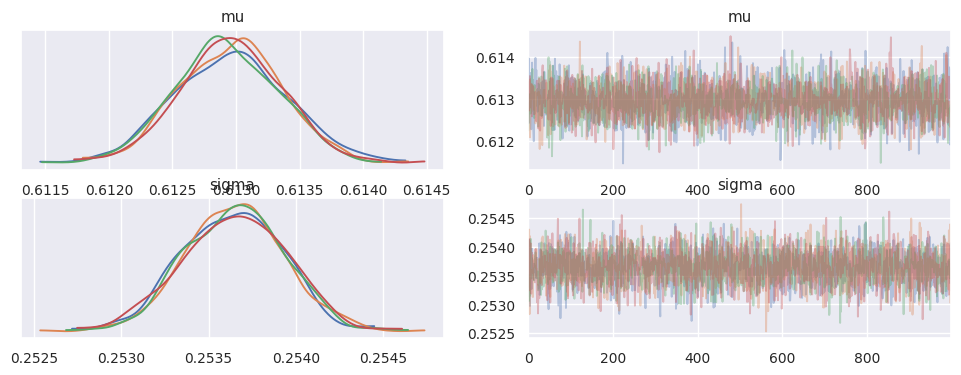

In [ ]:
az.plot_trace(trace, compact=False)

From image above, on the left, we have a KDE plot, – for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

The above plot has one row for each parameter. For this model, the posterior is bi-dimensional, and so the above figure is showing the marginal distributions of each parameter.

There are a couple of things to see here.

Our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

We can plot a joint distributions as plot pair (figure below) of parameters. We don't see any correlation between these two parameters. This means we probably do not have collinearity in the model which is this is good.

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

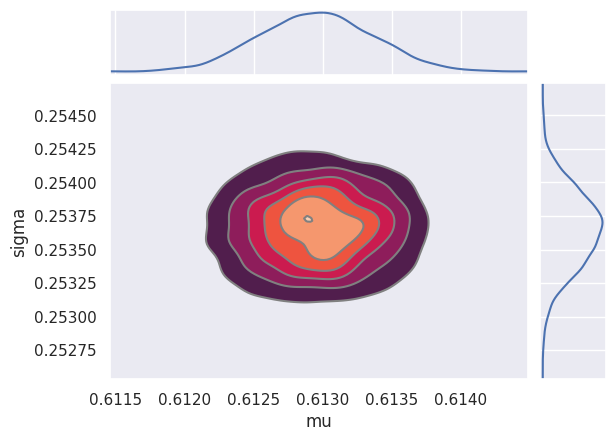

In [ ]:
az.plot_pair(trace, kind='kde', marginals=True)

In [ ]:
pd.set_option('display.float_format', '{:.8f}'.format)

We can also have a detailed summary of the posterior distribution for each parameter

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.61300000,0.00000000,0.61200000,0.61400000,0.00000000,0.00000000,3974.00000000,2592.00000000,1.00000000
sigma,0.25400000,0.00000000,0.25300000,0.25400000,0.00000000,0.00000000,3421.00000000,3213.00000000,1.00000000


**HDI: Highest Density Interval** - All points within this interval have a higher probability density than points outside the interval.

hdi_3% and hdi_97% one representing the left end of the interval (the value below which 3% of the posterior falls) and one representing the right end of the interval (the value above which 3% of the posterior falls)


We can also see the above summay visually by generating a plot with the mean and HPD of a distribution.

We get the mean, standard deviation (sd), and 94% HPD interval (hpd 3% and hpd 97%). we can use these numbers to interpret and report the results of a Bayesian inference below.

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

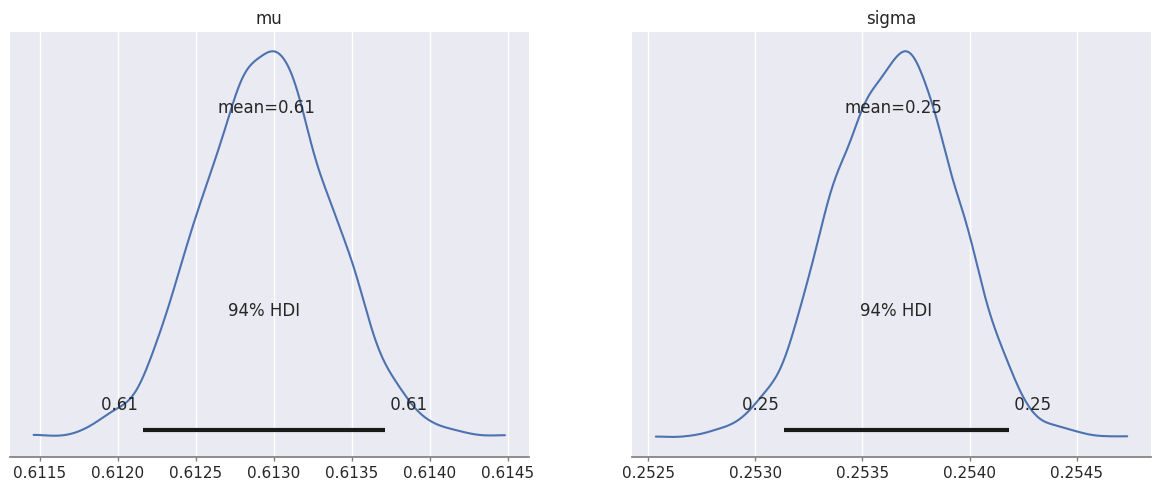

In [ ]:
az.plot_posterior(trace)

It can be seen, unlike Frequentist statistics, in Bayesian statistics, we get the entire distribution of the values.

Every time ArviZ computes and reports a HPD, it will use, by default, a value of 94%. HPD intervals are not the same as confidence intervals. There is 94% probability the belief is around 1.20 for the mean leaf shape

Now, we use bar plot of the autocorrelation function (ACF) for a sequence of time series data.

The ACF plots are helpful as a convergence diagnostic for posteriors from MCMC samples which display autocorrelation.

array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n2'}>,
        <Axes: title={'center': 'mu\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>]], dtype=object)

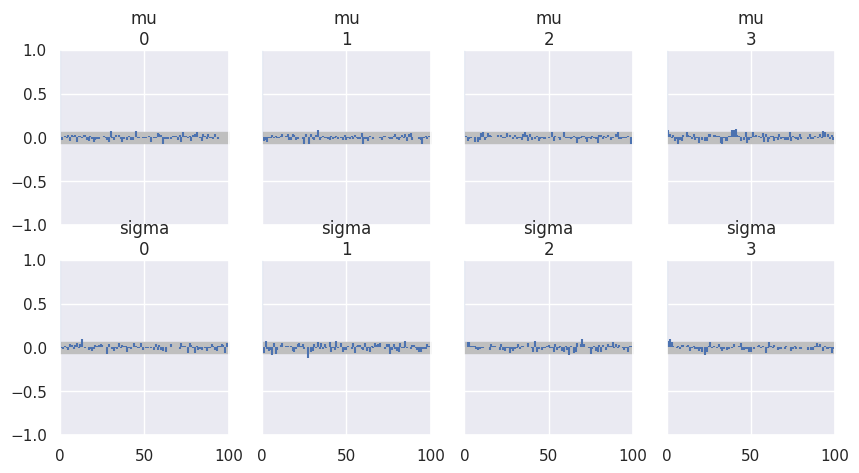

In [ ]:
pm.plots.plot_autocorr(trace, figsize=(10,5))

It can be seen that all the blue line is around 0 which mean it is uncorrelated or random data. This means we probably do not have collinearity in the model which is this is good.

We can also verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

(tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical.


In [ ]:
#pm.gelman_rubin(trace_g)
az.rhat(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.003
    sigma    float64 1.002

It can be seen that the result value (mu & sigma) are around 1. Now we will plot it using BFMI energy plot

**Bayesian fraction of missing information (BFMI)**

BFMI quantifies how well momentum resampling matches the marginal energy distribution.

<Axes: >

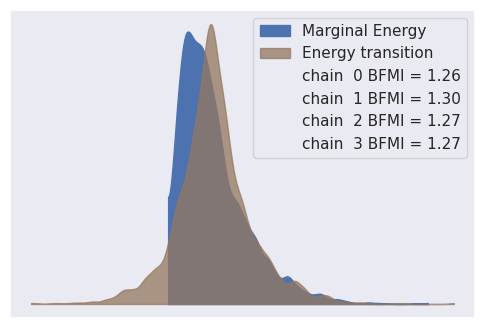

In [ ]:
bfmi = pm.bfmi(trace)
pm.plot_energy(trace, figsize=(6,4))

Our model has converged well and looks good.

## Evaluate Model

**Posterior Predictive Checks**

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.

The following function will randomly draw 1000 samples with 4 chains of parameters from the trace. Then, for each sample, it will draw leaf shape time series data (377,989) random numbers from a normal distribution specified by the values of mu and sigma in that sample.

In [ ]:
ppc = pm.sample_posterior_predictive(trace, model=model)

In [ ]:
ppc2 = ppc.posterior_predictive['y']
np.asarray(ppc2).shape

(4, 1000, 377, 988, 1)

Now, ppc contains 1000 generated data sets in 4 chains (containing 377x989 samples each), each using a different parameter setting from the posterior.

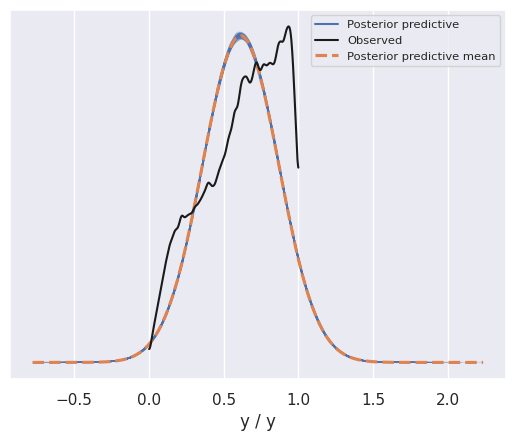

In [ ]:
az.plot_ppc(ppc, num_pp_samples=100);

It can be seen mean is very close to leaf shape mean

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

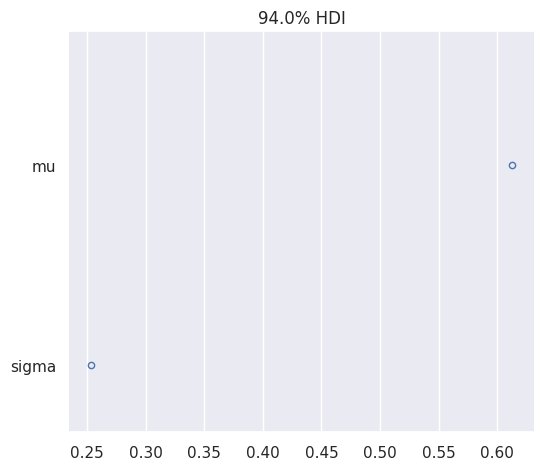

In [ ]:
az.plot_forest(trace, combined=True)

## extract features

In [ ]:
df10 = trace.posterior.to_dataframe()
df10

mu      sigma
chain draw                      
0     0    0.61241317 0.25400026
      1    0.61395984 0.25345508
      2    0.61242874 0.25314205
      3    0.61273910 0.25411884
      4    0.61257692 0.25297420
...               ...        ...
3     995  0.61301684 0.25398287
      996  0.61334991 0.25323710
      997  0.61311712 0.25337733
      998  0.61311712 0.25337733
      999  0.61268792 0.25369993

[4000 rows x 2 columns]

we take posterior predictive value as our feature

In [ ]:
ppc2

<xarray.DataArray 'y' (chain: 4, draw: 1000, y_dim_2: 377, y_dim_3: 988,
                       y_dim_4: 1)>
array([[[[[ 0.96928782],
          [ 0.70359423],
          [ 0.65511595],
          ...,
          [ 0.70695913],
          [ 0.62084035],
          [ 0.18699339]],

         [[ 0.49359966],
          [ 0.84702659],
          [ 0.62462816],
          ...,
          [ 0.47881769],
          [ 0.44438056],
          [ 0.84091513]],

         [[ 0.51055075],
          [ 0.70390049],
          [ 0.74001621],
          ...,
...
          ...,
          [ 0.29168329],
          [ 0.63449418],
          [ 0.40193848]],

         [[ 0.64218892],
          [ 1.18179772],
          [ 0.50383454],
          ...,
          [ 0.57943125],
          [ 0.88223295],
          [ 0.43891874]],

         [[ 0.4075978 ],
          [ 0.15132699],
          [ 0.45079219],
          ...,
          [ 0.30276293],
          [ 0.62393938],
          [ 0.71329636]]]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 ... 369 370 371 372 373 374 375 376
  * y_dim_3  (y_dim_3) int64 0 1 2 3 4 5 6 7 ... 980 981 982 983 984 985 986 987
  * y_dim_4  (y_dim_4) int64 0

In [ ]:
extract = ppc2[0, 0, 0, :, 0]
extract2 = ppc2[0, 0, :, :, 0]

In [ ]:
aa = pd.Series(extract)
aa

0     0.96928782
1     0.70359423
2     0.65511595
3     0.26676838
4     0.37670283
         ...    
983   0.93710153
984   0.55024937
985   0.70695913
986   0.62084035
987   0.18699339
Length: 988, dtype: float64

In [ ]:
bb = to_time_series_dataset(extract2)
bb

array([[[0.96928782],
        [0.70359423],
        [0.65511595],
        ...,
        [0.70695913],
        [0.62084035],
        [0.18699339]],

       [[0.49359966],
        [0.84702659],
        [0.62462816],
        ...,
        [0.47881769],
        [0.44438056],
        [0.84091513]],

       [[0.51055075],
        [0.70390049],
        [0.74001621],
        ...,
        [1.0337982 ],
        [0.67688243],
        [0.3707725 ]],

       ...,

       [[0.55614276],
        [0.4130466 ],
        [0.82211924],
        ...,
        [0.05956278],
        [0.35812927],
        [0.9637461 ]],

       [[0.19429124],
        [0.92095491],
        [0.86547715],
        ...,
        [0.59725528],
        [0.59389653],
        [0.66955997]],

       [[0.63521703],
        [0.57757029],
        [0.69545039],
        ...,
        [0.47363567],
        [0.42520652],
        [0.71132168]]])

In [ ]:
bb.shape

(377, 988, 1)

In [222]:
x_2d = resampled_X.reshape(377, 988)

In [ ]:
data_2d = bb.reshape(377, 988)

In [ ]:
data_2d

array([[0.96928782, 0.70359423, 0.65511595, ..., 0.70695913, 0.62084035,
        0.18699339],
       [0.49359966, 0.84702659, 0.62462816, ..., 0.47881769, 0.44438056,
        0.84091513],
       [0.51055075, 0.70390049, 0.74001621, ..., 1.0337982 , 0.67688243,
        0.3707725 ],
       ...,
       [0.55614276, 0.4130466 , 0.82211924, ..., 0.05956278, 0.35812927,
        0.9637461 ],
       [0.19429124, 0.92095491, 0.86547715, ..., 0.59725528, 0.59389653,
        0.66955997],
       [0.63521703, 0.57757029, 0.69545039, ..., 0.47363567, 0.42520652,
        0.71132168]])

##Validating Data Augmentation

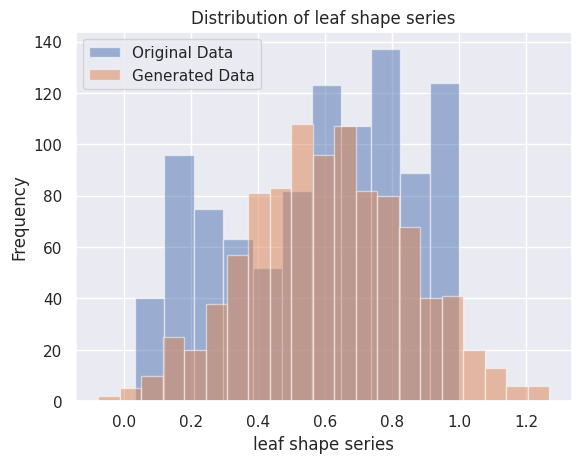

In [ ]:
def plot_distribution(original_data, generated_data, feature_name):
    # Plot histogram for the original data
    plt.hist(original_data, bins='auto', alpha=0.5, label='Original Data')

    # Plot histogram for the generated data
    plt.hist(generated_data, bins='auto', alpha=0.5, label='Generated Data')

    # Set plot title and labels
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

# Assuming 'original_series' and 'generated_series' are the original and generated series datasets, respectively
feature_name = 'leaf shape series'  # Replace with the name of the feature being compared

# Plot the distribution of the feature for original and generated series
plot_distribution(series_resample, aa, feature_name)


In [216]:
x_2d = resampled_X.reshape(377, 988)
x_2d.shape

(377, 988)

In [224]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(x_2d, yy)

# Predict the labels for the test data
y_pred = rf_classifier.predict(data_2d)

# Evaluate the classifier
report = classification_report(yy, y_pred)
print(report)


              precision    recall  f1-score   support

           1       0.29      0.96      0.45       109
           2       0.00      0.00      0.00        73
           3       0.38      0.07      0.12        84
           4       0.00      0.00      0.00        87
           5       0.00      0.00      0.00        24

    accuracy                           0.29       377
   macro avg       0.13      0.21      0.11       377
weighted avg       0.17      0.29      0.16       377



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [225]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

[[105   1   3   0   0]
 [ 69   0   4   0   0]
 [ 78   0   6   0   0]
 [ 84   0   3   0   0]
 [ 24   0   0   0   0]]


Text(0.5, 1.0, 'Data augmentation confusion matrix')

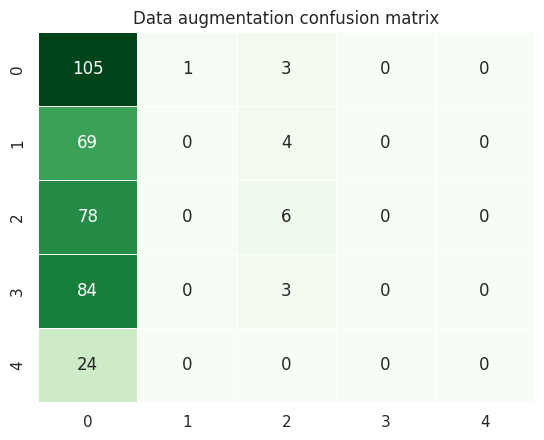

In [236]:
conf_m = metrics.confusion_matrix(yy, y_pred)
print(conf_m)
sns.heatmap(conf_m, annot = True,  linewidths=.5, cbar =None, fmt='g', cmap='Greens')
plt.title('Data augmentation confusion matrix')

In [238]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision score
precision = precision_score(yy, y_pred, average='weighted')

# Calculate recall score
recall = recall_score(yy, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.16788240495137047
Recall: 0.29442970822281167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [266]:
import numpy as np
import pandas as pd

def extract_features(series):
    # Extracting features from each series
    area = np.sum(series)  # Calculate the total area
    perimeter = np.sum(np.abs(np.diff(series)))  # Calculate the perimeter
    compactness = perimeter ** 2 / area  # Calculate the compactness
    eccentricity = np.max(series) / np.sum(series)  # Calculate the eccentricity

    return area, perimeter, compactness, eccentricity

# Assuming 'data' is the 3-dimensional array containing the unequal time series data
num_samples = bb.shape[0]  # Number of samples

# Initialize empty lists to store the extracted features
areas = []
perimeters = []
compactnesses = []
eccentricities = []

# Extract features for each sample in the data
for i in range(num_samples):
    series = data[i].squeeze()  # Extract the series for a given sample and squeeze it to 1-dimensional
    area, perimeter, compactness, eccentricity = extract_features(series)

    # Append the extracted features to the respective lists
    areas.append(area)
    perimeters.append(perimeter)
    compactnesses.append(compactness)
    eccentricities.append(eccentricity)

# Create a DataFrame to store the extracted features
df_features = pd.DataFrame({
    'Area': areas,
    'Perimeter': perimeters,
    'Compactness': compactnesses,
    'Eccentricity': eccentricities,
    'y': y
})

# Print the DataFrame
print(df_features)


            Area  Perimeter  Compactness  Eccentricity          y
0   574.81814721 4.43135653   0.03416197    0.00173968 1.00000000
1   593.07940760 3.22398774   0.01752564    0.00168611 1.00000000
2   580.09690729 4.61743728   0.03675373    0.00172385 1.00000000
3   577.15600000 4.78640000   0.03969399    0.00173263 1.00000000
4   544.55546535 4.50983495   0.03734902    0.00183636 1.00000000
..           ...        ...          ...           ...        ...
372 628.29873576 4.18773810   0.02791212    0.00159160 5.00000000
373 634.61011773 4.77078045   0.03586509    0.00157577 5.00000000
374 594.51384498 4.26166413   0.03054896    0.00168205 5.00000000
375 597.19659949 3.38275329   0.01916123    0.00167449 5.00000000
376 607.81258146 3.13726565   0.01619321    0.00164524 5.00000000

[377 rows x 5 columns]


save data augmentation to csv

In [265]:
df_features.to_csv('df_synthetic_data.csv')

done!